Detected 62 signals (after SNR filter) → F:/test/detected_signals.csv


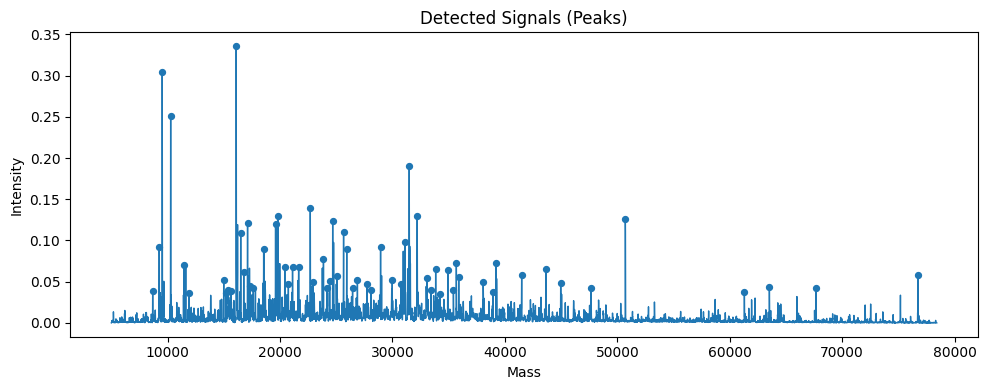

Plot saved → F:/test/spectrum_with_peaks.png


In [11]:
# -*- coding: utf-8 -*-
"""
Detect signals (peaks) from a space-separated CSV/text file with two columns:
mass intensity

Adds a minimum SNR requirement.
- Works as a script or in a Jupyter cell.
- Requires: numpy, pandas, scipy, matplotlib
  pip install numpy pandas scipy matplotlib
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from dataclasses import dataclass
from pathlib import Path


# -----------------------------
# Parameters
# -----------------------------
@dataclass
class PeakFindingParams:
    """
    Parameters for peak detection.
    - If min_prominence/min_height are None, they are auto-set using a robust noise estimate.
    - min_snr filters peaks AFTER detection based on intensity / noise_sigma.
    """
    min_prominence: float | None = None
    min_height: float | None = None
    min_distance_pts: int = 10    # minimum index gap between peaks
    smooth_window: int = 0        # 0 = no smoothing; otherwise odd (3,5,7,...)
    min_snr: float = 0.0          # minimum SNR to keep a peak (0 = disabled)


# -----------------------------
# Helpers
# -----------------------------
def _mad_sigma(y: np.ndarray) -> float:
    """Robust noise estimate: sigma ≈ 1.4826 * MAD."""
    if y.size == 0:
        return 0.0
    med = np.median(y)
    mad = np.median(np.abs(y - med))
    return 1.4826 * mad


def _smooth(y: np.ndarray, window: int) -> np.ndarray:
    """Simple moving-average smoothing (odd window length)."""
    if window < 3 or window % 2 == 0:
        return y
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(y, kernel, mode="same")


# -----------------------------
# Core functions
# -----------------------------
def detect_signals(
    df: pd.DataFrame,
    params: PeakFindingParams = PeakFindingParams()
) -> pd.DataFrame:
    """
    Detect peaks in a two-column DataFrame with columns ['mass','intensity'].
    Returns a DataFrame with columns: mass, intensity, prominence, bases, snr.
    Applies an optional SNR filter (params.min_snr) after detection.
    """
    # Validate/normalize columns
    if not {"mass", "intensity"}.issubset(df.columns):
        if df.shape[1] >= 2:
            df = df.copy()
            df.columns = ["mass", "intensity"] + [f"col{i}" for i in range(2, df.shape[1])]
        else:
            raise ValueError("Input DataFrame must have columns ['mass','intensity'].")

    # Clean & sort
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["mass", "intensity"])
    df = df.sort_values("mass").reset_index(drop=True)

    x = df["mass"].to_numpy(dtype=float)
    y = df["intensity"].to_numpy(dtype=float)

    # Optional smoothing for detection only
    y_proc = _smooth(y, params.smooth_window)

    # Robust noise estimate and dynamic defaults
    sigma = _mad_sigma(y_proc)
    ymax = float(np.max(y_proc)) if y_proc.size else 0.0

    min_prom = params.min_prominence
    min_h = params.min_height
    if min_prom is None:
        # 6σ or 0.1% of max, whichever is larger
        min_prom = max(6.0 * sigma, 0.001 * ymax)
    if min_h is None:
        # 4σ or 0.05% of max, whichever is larger
        min_h = max(4.0 * sigma, 0.0005 * ymax)

    # Peak finding (on smoothed signal), report original intensities
    peaks, props = find_peaks(
        y_proc,
        prominence=min_prom,
        height=min_h,
        distance=max(1, int(params.min_distance_pts))
    )

    out = pd.DataFrame({
        "mass": x[peaks],
        "intensity": y[peaks],  # original (unsmoothed)
        "prominence": props.get("prominences", np.full(peaks.shape, np.nan, dtype=float)),
        "left_base_idx": props.get("left_bases", np.full(peaks.shape, -1, dtype=int)),
        "right_base_idx": props.get("right_bases", np.full(peaks.shape, -1, dtype=int)),
    })

    # SNR = intensity / sigma (fallbacks to std if needed; never divide by 0)
    snr_den = sigma if sigma > 0 else (np.std(y_proc) if y_proc.size else 1.0)
    snr_den = snr_den if snr_den > 0 else 1.0
    out["snr"] = out["intensity"] / snr_den

    # Apply SNR filter if requested
    if params.min_snr > 0:
        out = out[out["snr"] >= params.min_snr].reset_index(drop=True)

    # Sort strongest first
    out = out.sort_values("intensity", ascending=False).reset_index(drop=True)
    return out


def load_space_separated(path: str | Path) -> pd.DataFrame:
    """Load a space-separated file with two numeric columns (mass, intensity)."""
    path = Path(path)
    df = pd.read_csv(
        path,
        sep=r"\s+",
        engine="python",
        header=None,
        names=["mass", "intensity"],
        comment="#",
    )
    return df


def plot_spectrum_with_peaks(
    df: pd.DataFrame,
    peaks_df: pd.DataFrame,
    out_png: str | Path | None = None,
    title: str = "Detected Signals"
) -> None:
    """Plot spectrum and mark detected peaks."""
    plt.figure(figsize=(10, 4))
    plt.plot(df["mass"].values, df["intensity"].values, linewidth=1)
    if not peaks_df.empty:
        plt.scatter(peaks_df["mass"].values, peaks_df["intensity"].values, s=18)
    plt.xlabel("Mass")
    plt.ylabel("Intensity")
    plt.title(title)
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=150)
    plt.show()


# -----------------------------
# Script entry point
# -----------------------------
if __name__ == "__main__":
    # ----------- USER SETTINGS -----------
    INPUT_PATH = r"F:/decon/decon/5__pos_1__neg_0_pos_runA_mass.txt"  # e.g., r"F:/decon/decon/75__pos_1__neg_0_pos_runA_mass.txt"
    OUTPUT_CSV = r"F:/test/detected_signals.csv"
    OUTPUT_PNG = r"F:/test/spectrum_with_peaks.png"

    params = PeakFindingParams(
        min_prominence=None,   # set float to force; or None for auto
        min_height=None,       # set float to force; or None for auto
        min_distance_pts=20,   # increase to merge neighbors; decrease to split
        smooth_window=0,       # try 5 or 7 if noisy
        min_snr=10.0            # keep peaks with SNR >= 5 (set 0.0 to disable)
    )
    # ------------------------------------

    # Load, detect, save, and plot
    df_in = load_space_separated(INPUT_PATH)
    peaks = detect_signals(df_in, params=params)
    peaks.to_csv(OUTPUT_CSV, index=False)
    print(f"Detected {len(peaks)} signals (after SNR filter) → {OUTPUT_CSV}")

    plot_spectrum_with_peaks(df_in, peaks, out_png=OUTPUT_PNG, title="Detected Signals (Peaks)")
    print(f"Plot saved → {OUTPUT_PNG}")
